In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
%matplotlib inline
from scipy.stats import norm, multivariate_normal

#Ahora las funciones utiles de sklearn para preprocesar datos y armar un pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures 

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error 

# Las estrellas de este notebook
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn import tree
from sklearn.linear_model import LinearRegression, RidgeCV

# Clasificación

En este clase vamos a implementar Árboles de Decisión con ayuda de `sklearn`. Introduzcamos el dataset primero:

Utilizando el siguiente archivo

In [ ]:
import os
import sys
if 'google.colab' in sys.modules:
        
    import tarfile
    !mkdir datasets
    DOWNLOAD_URL = "https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/main/datasets/season-1112_csv.csv?token=ANMPRUFCMWUWGESNOOOY4BTAULCFY"
    !wget {DOWNLOAD_URL} -P {"datasets/"} 
    !mv {"datasets/season-1112_csv.csv?token=ANMPRUFCMWUWGESNOOOY4BTAULCFY"} {"datasets/season-1112_csv.csv"} 
else: 
    print("Not running on Google Colab. This cell is did not do anything.")

--2021-05-11 17:25:10--  https://raw.githubusercontent.com/IAI-UNSAM/ML_UNSAM/main/datasets/season-1112_csv.csv?token=ANMPRUFCMWUWGESNOOOY4BTAULCFY
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106303 (104K) [text/plain]
Saving to: ‘datasets/season-1112_csv.csv?token=ANMPRUFCMWUWGESNOOOY4BTAULCFY’

season-1112_csv.csv 100%[===================>] 103.81K  --.-KB/s    in 0.02s   

2021-05-11 17:25:10 (6.54 MB/s) - ‘datasets/season-1112_csv.csv?token=ANMPRUFCMWUWGESNOOOY4BTAULCFY’ saved [106303/106303]



In [ ]:
df = pd.read_csv('datasets/season-1112_csv.csv')#https://datahub.io/sports-data/english-premier-league y https://www.football-data.co.uk/notes.txt

Este archivo consiste en todos los partidos de la temporada 2011-2012 de la Premier League.
Para cada partido se listan los goles del local y del visitante tanto al final como a la mitad del partido. Además, se listan los disparos, los disparos al arco, las faltas cometidas, las tarjetas amarillas, las tarjetas rojas y las distintas apuestas de sitios conocidos.

In [ ]:
df.head()

,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,Referee,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR,B365H,B365D,B365A,BWH,BWD,BWA,GBH,GBD,GBA,IWH,IWD,IWA,LBH,LBD,LBA,SBH,SBD,SBA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,BSH,BSD,BSA,Bb1X2,BbMxH,BbAvH,BbMxD,BbAvD,BbMxA,BbAvA,BbOU,BbMx>2.5,BbAv>2.5,BbMx<2.5,BbAv<2.5,BbAH,BbAHh,BbMxAHH,BbAvAHH,BbMxAHA,BbAvAHA
0,E0,13/08/11,Blackburn,Wolves,1,2,A,1,1,D,K Friend,16,13,8,4,14,10,12,6,4,2,0,0,2.20,3.20,3.5,2.00,3.30,3.60,2.10,3.20,3.5,2.0,3.3,3.3,2.00,3.40,3.75,2.0,3.25,3.40,2.20,3.10,3.50,2.05,3.40,3.60,2.15,3.4,3.60,2.00,3.40,3.60,37,2.22,2.13,3.43,3.29,3.75,3.52,37,2.06,1.96,1.89,1.82,18,-0.50,2.20,2.14,1.78,1.74
1,E0,13/08/11,Fulham,Aston Villa,0,0,D,0,0,D,L Mason,13,7,9,1,10,18,2,3,2,4,0,0,2.20,3.20,3.5,2.05,3.30,3.45,2.10,3.20,3.5,2.2,3.2,3.0,2.20,3.30,3.30,2.1,3.20,3.20,2.20,3.20,3.40,2.10,3.30,3.50,2.15,3.3,3.75,2.10,3.25,3.40,38,2.20,2.12,3.43,3.28,3.86,3.53,34,2.21,2.11,1.77,1.69,21,-0.25,1.83,1.80,2.14,2.08
2,E0,13/08/11,Liverpool,Sunderland,1,1,D,1,0,H,P Dowd,11,15,4,6,17,12,6,3,4,4,0,0,1.57,3.60,7.0,1.45,3.85,7.50,1.50,3.75,7.0,1.4,4.1,7.0,1.50,3.75,7.50,1.4,4.00,7.50,1.57,3.75,6.50,1.50,3.90,7.50,1.53,4.0,7.50,1.50,3.75,7.00,37,1.57,1.50,4.20,3.92,8.04,7.30,37,1.92,1.85,2.01,1.92,21,-1.00,1.92,1.88,2.02,1.98
3,E0,13/08/11,Newcastle,Arsenal,0,0,D,0,0,D,P Walton,6,9,1,4,9,11,2,5,3,5,0,1,3.75,3.25,2.1,3.65,3.25,2.00,3.75,3.20,2.0,3.7,3.3,1.9,3.75,3.40,2.00,3.4,3.40,1.95,3.75,3.20,2.05,4.00,3.50,1.91,3.80,3.4,2.10,3.75,3.25,2.05,36,4.00,3.68,3.52,3.35,2.15,2.05,34,1.89,1.80,2.10,1.98,20,0.50,1.84,1.79,2.16,2.10
4,E0,13/08/11,QPR,Bolton,0,4,A,0,1,A,M Atkinson,13,13,7,7,9,16,3,2,1,2,1,0,2.40,3.25,3.0,2.25,3.25,3.05,2.30,3.20,3.0,2.3,3.2,2.8,2.38,3.25,3.00,2.3,3.20,2.80,2.40,3.10,3.10,2.30,3.25,3.20,2.38,3.3,3.30,2.30,3.25,3.10,37,2.40,2.30,3.40,3.26,3.40,3.14,34,2.27,2.16,1.73,1.66,19,-0.25,2.00,1.95,1.98,1.92


In [ ]:
len(df)

380

In [ ]:
column_names = df.columns

In [ ]:
column_names

Index(['Div', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'HTHG',
       'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 'HC',
       'AC', 'HY', 'AY', 'HR', 'AR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],
      dtype='object')

¿Qué se les ocurre que podemos hacer?

Mi idea es aprender quien gana en base a los otros features

Hagamos una copia antes de empezar

In [ ]:
df_copia=df.copy()#[['HomeTeam','AwayTeam', 'FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR','HS','AS','HST', 'AST','HF','AF', 'HY', 'AY', 'HR', 'AR']]

In [ ]:
df_copia_train, df_copia_test = train_test_split(df_copia)

Hagamos una primera exploración para recordar como funciona el Árbol de Decisión.

Para poder graficar, primero consideremos únicamente dos features

In [ ]:
target_train=np.zeros(len(df_copia_train))
target_train[df_copia_train['FTR']=='H']=1.0
target_train[df_copia_train['FTR']=='D']=0.0
target_train[df_copia_train['FTR']=='A']=-1.0
features_train=np.asarray(df_copia_train[['FTHG','FTAG']])

target_test=np.zeros(len(df_copia_test))
target_test[df_copia_test['FTR']=='H']=1.0
target_test[df_copia_test['FTR']=='D']=0.0
target_test[df_copia_test['FTR']=='A']=-1.0
features_test=np.asarray(df_copia_test[['FTHG','FTAG']])

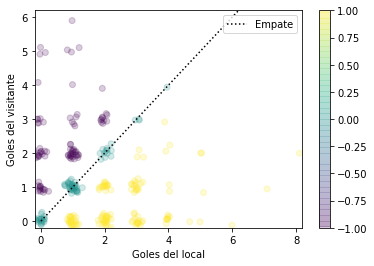

In [ ]:
features_scatter=features_train+0.1*np.random.randn(len(features_train),2)
plt.scatter(features_scatter[:,0],features_scatter[:,1],c=target_train,alpha=0.2)
plt.colorbar()
xvals=np.linspace(0.0,8.0,10)
plt.plot(xvals,xvals,linestyle='dotted', color='black',label='Empate')
plt.xlabel('Goles del local')
plt.ylabel('Goles del visitante')
plt.xlim(-0.2,8.2)
plt.ylim(-0.2,6.2)
plt.legend(loc='upper right')


Si yo me olvido de que tengo hiperparametros:

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(features_train,target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Veamos como se ve graficamente esto

In [ ]:
dt.predict(np.asarray([1.0,2.0]).reshape(1,-1))

array([-1.])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: The following kwargs were not used by contour: 'label'
  """


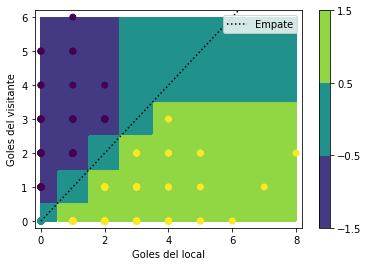

In [ ]:
xvals=np.linspace(0.0,8.0,100)
yvals=np.linspace(0.0,6.0,100)
X, Y = np.meshgrid(xvals,yvals)
Z = dt.predict(np.c_[X.ravel(),Y.ravel()]).reshape(X.shape)
plt.contourf(xvals,yvals,Z, levels=[-1.5,-0.5,0.5,1.5],label='DT')
plt.colorbar()
plt.scatter(features_train[:,0],features_train[:,1],c=target_train)
plt.plot(xvals,xvals,linestyle='dotted', color='black',label='Empate')
plt.xlabel('Goles del local')
plt.ylabel('Goles del visitante')
plt.xlim(-0.2,8.2)
plt.ylim(-0.2,6.2)
plt.legend(loc='upper right')

Hace cosas complicadisimas!

Está sobreajustando. Esto no se ve en la matriz de confusión:

In [ ]:
print(confusion_matrix(target_train,dt.predict(features_train)))
print(confusion_matrix(target_test,dt.predict(features_test)))

[[ 88   0   0]
 [  0  71   0]
 [  0   0 126]]
[[27  1  0]
 [ 0 22  0]
 [ 0  0 45]]


Pero podemos verlo dibujando el árbol:

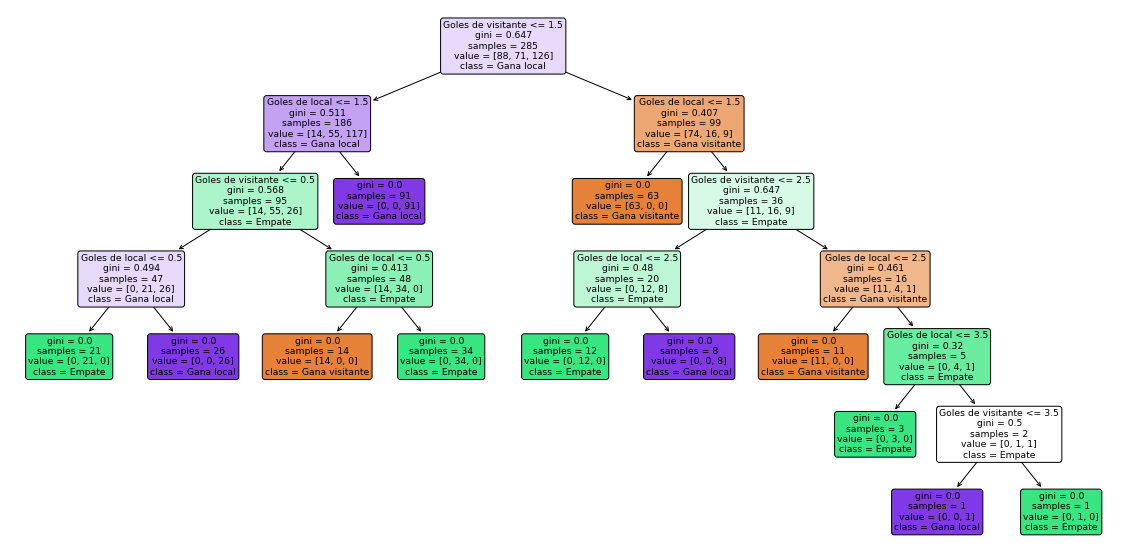

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(dt,filled=True,rounded=True,feature_names=["Goles de local","Goles de visitante"],class_names=["Gana visitante","Empate","Gana local"]) 
plt.show()

O si quieren lo pueden exportar como un ".dot" y convertirlo a ".png" para la posteridad.

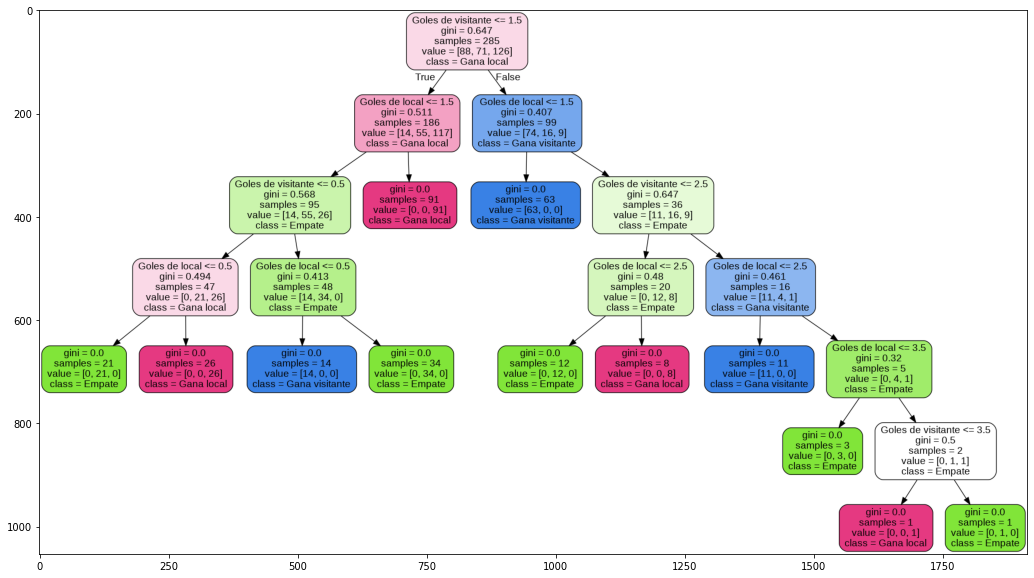

In [ ]:
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=["Goles de local","Goles de visitante"],
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

Se va fijando la cantidad de goles...  Pero nosotros sabemos que lo único que importa es hacer más goles que el rival. Este es un limitante de los DTs. Hace cortes en cada parametro por separado, no piensa en combinarlos inteligentemente. Esta es la razón por la que tampoco hace falta estandarizar los datos.

Veamos que pasa con un poco de feature engineering

In [ ]:
features_train=df_copia_train[['FTHG','FTAG']]
features_train['Local - Visitante'] = features_train['FTHG']-features_train['FTAG']
features_train=np.asarray(features_train)

features_test=df_copia_test[['FTHG','FTAG']]
features_test['Local - Visitante'] = features_test['FTHG']-features_test['FTAG']
features_test=np.asarray(features_test)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
dt = DecisionTreeClassifier()
dt.fit(features_train,target_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

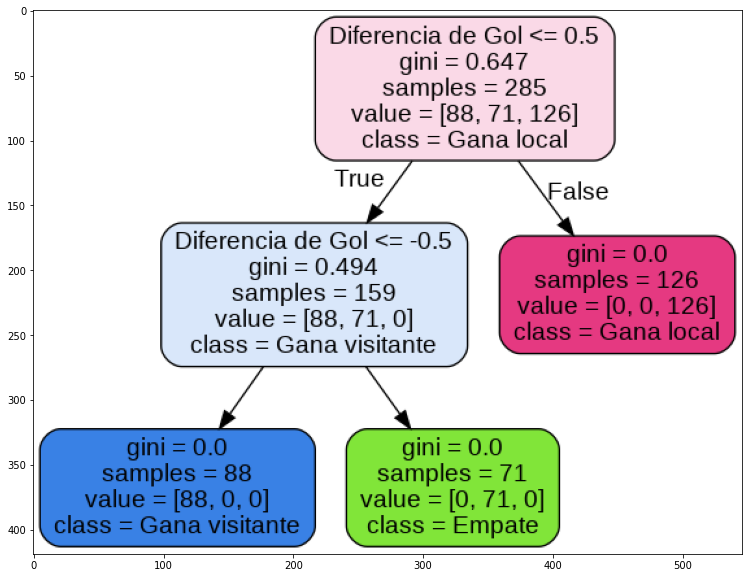

In [ ]:
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=["Goles de local","Goles de visitante","Diferencia de Gol"],
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

Acá hace lo que tiene que hacer.

Generalmente, si tuviesemos algo tan fácil no vale la pena hacer un DT. Trabajemos ahora con todos los features que no nos dicen directamente quién ganó. También me voy a sacar de encima las apuestas.

In [ ]:
nombres_train=df_copia_train[['HomeTeam','AwayTeam']]
features_train=df_copia_train.drop(['Div','Date','Referee','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],axis=1)

nombres_test=df_copia_test[['HomeTeam','AwayTeam']]
features_test=df_copia_test.drop(['Div','Date','Referee','HomeTeam','AwayTeam','FTHG','FTAG','FTR','HTHG', 'HTAG', 'HTR', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',
       'BWA', 'GBH', 'GBD', 'GBA', 'IWH', 'IWD', 'IWA', 'LBH', 'LBD', 'LBA',
       'SBH', 'SBD', 'SBA', 'WHH', 'WHD', 'WHA', 'SJH', 'SJD', 'SJA', 'VCH',
       'VCD', 'VCA', 'BSH', 'BSD', 'BSA', 'Bb1X2', 'BbMxH', 'BbAvH', 'BbMxD',
       'BbAvD', 'BbMxA', 'BbAvA', 'BbOU', 'BbMx>2.5', 'BbAv>2.5', 'BbMx<2.5',
       'BbAv<2.5', 'BbAH', 'BbAHh', 'BbMxAHH', 'BbAvAHH', 'BbMxAHA',
       'BbAvAHA'],axis=1)

In [ ]:
features_train

,HS,AS,HST,AST,HF,AF,HC,AC,HY,AY,HR,AR
122,23,8,13,6,12,15,11,3,1,4,0,1
83,20,16,13,14,14,11,8,13,2,0,0,0
105,18,16,9,8,5,14,3,1,1,1,0,0
328,9,10,6,7,9,4,6,4,3,0,1,0
49,23,3,14,3,7,9,9,2,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13,15,12,5,10,17,7,7,6,3,3,1,0
135,7,16,4,10,8,12,4,5,3,2,0,0
30,20,13,13,9,14,1,5,7,2,0,0,0
78,17,13,11,10,14,12,2,11,0,1,0,0


Yo separé los nombres porque no me interesan a la hora de aprender pero el DT podría utilizarlos si lo convierto a variable categórica.

Vamos a regularizar el algoritmo. Recuerden que este tiene distintos parametros. En particular, podemos elegir si utiliza Gini o Entropia para calcular la impureza de un splitting. Generalmente no hay diferencia pero por definicion Gini puede favorecer mas la clase mas frecuente. La ventaja es que es mas rapida.

Yendo a los otros hiperparametros, las opciones que tenemos en sklearn son:

    max_depth: por defecto es None, controla la profundidad del arbol.
    min_samples_split: establece el minimo numero de muestras que debe tener un nodo para poder seguir partiendolo.
    min_samples_leaf: el minimo numero de muestras que debe tener una hoja (ie nodo final).
    min_weight_fraction_leaf: la minima fraccion pesada de muestras que debe poseer una hoja.
    max_leaf_nodes: maxima cantidad de hojas.
    max_features: maxima cantidad de features evaluados en un splitting.

Si uno sube los valores minimos o baja los maximos, esta restringiendo al arbol y regularizando el modelo.

Existen otros metodos de regularizacion como por ejemplo el pruning o podado de arboles en el que se entrena sin restricciones y luego se eliminan nodos innecesarios.


Juguemos un poco:

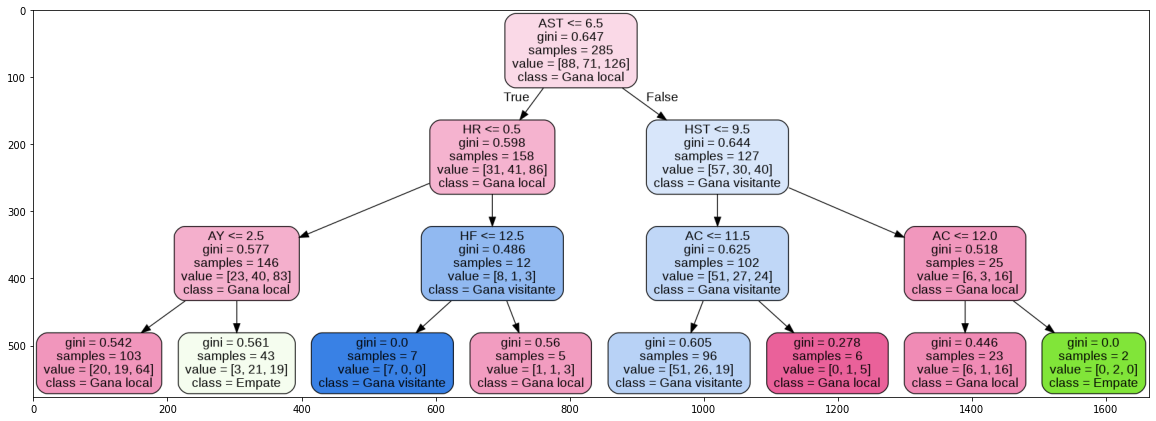

In [ ]:
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

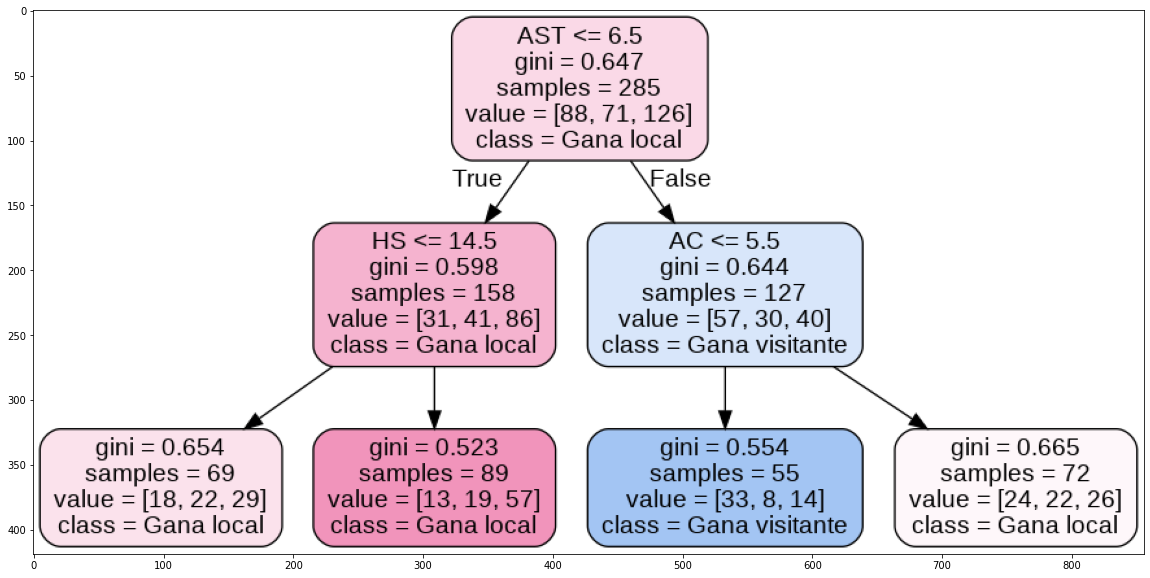

In [ ]:
dt = DecisionTreeClassifier(min_samples_leaf=min_samples_leaf50,max_depth=100)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

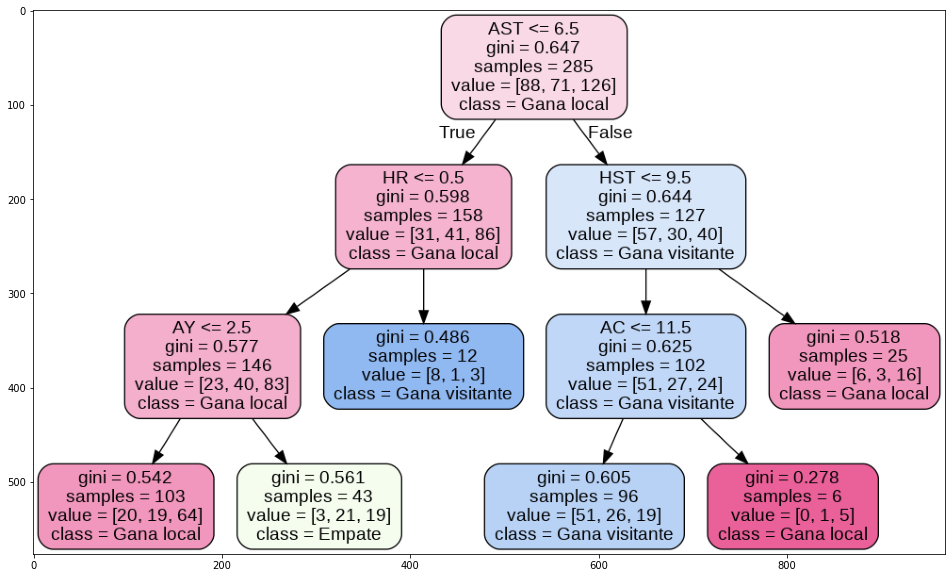

In [ ]:
dt = DecisionTreeClassifier(max_leaf_nodes=6)
dt.fit(features_train,target_train)
tree.export_graphviz(
dt,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

In [ ]:
dt = DecisionTreeClassifier()
params={'max_depth':[3,5,10],'min_samples_leaf':[10,25,50], 'max_leaf_nodes':[5,10,100]}
grilla=GridSearchCV(dt,params,cv=10,scoring='accuracy')
grilla.fit(features_train,target_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=None,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [3, 5, 10],
                         'm

In [ ]:
grilla.best_params_

{'max_depth': 3, 'max_leaf_nodes': 5, 'min_samples_leaf': 10}

In [ ]:
modelo=grilla.best_estimator_

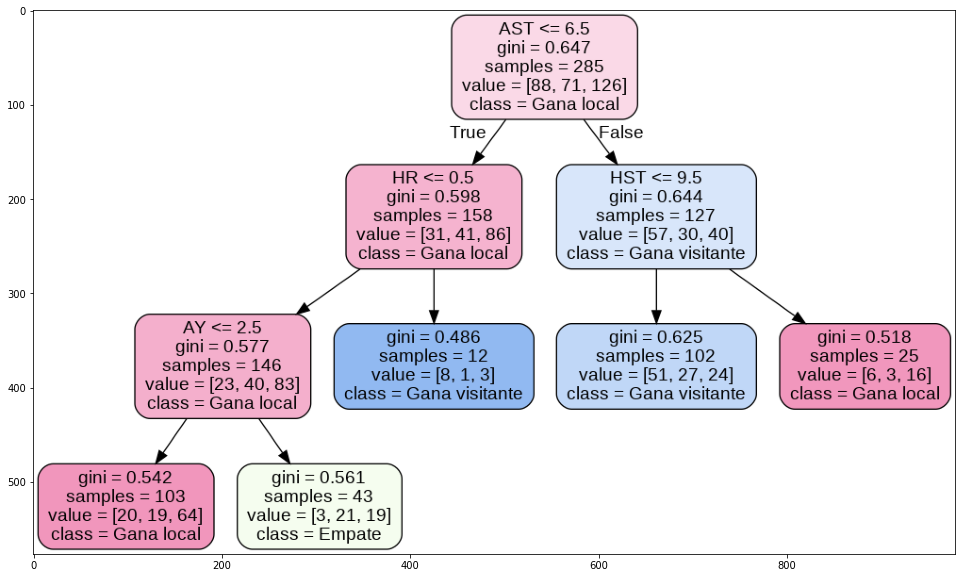

In [ ]:
tree.export_graphviz(
modelo,
out_file="futbol.dot",
feature_names=features_train.columns,
class_names=["Gana visitante","Empate","Gana local"],
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng futbol.dot -o futbol.png

#Ploteamos el png
img = cv2.imread('futbol.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

In [ ]:
from sklearn.metrics import precision_score, recall_score
print(confusion_matrix(target_train,modelo.predict(features_train)))
print(recall_score(np.where(target_train==-1.0,1.0,0.0),np.where(modelo.predict(features_train)==-1.0,1.0,0.0)))
print(recall_score(np.where(target_train==0.0,1.0,0.0),np.where(modelo.predict(features_train)==0.0,1.0,0.0)))
print(recall_score(np.where(target_train==1.0,1.0,0.0),np.where(modelo.predict(features_train)==1.0,1.0,0.0)))

print(accuracy_score(np.where(target_train==-1.0,1.0,0.0),np.where(modelo.predict(features_train)==-1.0,1.0,0.0)))
print(accuracy_score(np.where(target_train==0.0,1.0,0.0),np.where(modelo.predict(features_train)==0.0,1.0,0.0)))
print(accuracy_score(np.where(target_train==1.0,1.0,0.0),np.where(modelo.predict(features_train)==1.0,1.0,0.0)))

print(confusion_matrix(target_test,modelo.predict(features_test)))

[[59  3 26]
 [28 21 22]
 [27 19 80]]
0.6704545454545454
0.29577464788732394
0.6349206349206349
0.7052631578947368
0.7473684210526316
0.6701754385964912
[[15  1 12]
 [ 8  3 11]
 [11  7 27]]


In [ ]:
print(modelo.predict_proba(features_train[:3]))
print(np.argmax(modelo.predict_proba(features_train[:3]),axis=1)-1)
print(modelo.predict(features_train[:3]))

[[0.06976744 0.48837209 0.44186047]
 [0.24       0.12       0.64      ]
 [0.5        0.26470588 0.23529412]]
[ 0  1 -1]
[ 0.  1. -1.]


In [ ]:
print(np.where(modelo.predict(features_train[:3])==-1.0,1.0,0.0))
print(np.where(modelo.predict(features_train[:3])==0.0,1.0,0.0))
print(np.where(modelo.predict(features_train[:3])==1.0,1.0,0.0))

[0. 0. 1.]
[1. 0. 0.]
[0. 1. 0.]


In [ ]:
umbrales=[0.2, 0.4,0.6, 0.8]
for umbral in umbrales:
  print("Umbral "+str(umbral)+'\n')
  y_pred_visi=np.where(modelo.predict_proba(features_train)[:,0]>=umbral,1.0,0.0)
  y_pred_emp=np.where(modelo.predict_proba(features_train)[:,1]>=umbral,1.0,0.0)
  y_pred_loc=np.where(modelo.predict_proba(features_train)[:,2]>=umbral,1.0,0.0)
  print(accuracy_score(np.where(target_train==-1.0,1.0,0.0),y_pred_visi))
  print(accuracy_score(np.where(target_train==0.0,1.0,0.0),y_pred_emp))
  print(accuracy_score(np.where(target_train==1.0,1.0,0.0),y_pred_loc))
  print("\n")

Umbral 0.2

0.6596491228070176
0.5789473684210527
0.4421052631578947


Umbral 0.4

0.7052631578947368
0.7473684210526316
0.6526315789473685


Umbral 0.6

0.7052631578947368
0.7508771929824561
0.6701754385964912


Umbral 0.8

0.6912280701754386
0.7508771929824561
0.5578947368421052




In [ ]:
print(recall_score(np.where(target_train==-1.0,1.0,0.0),np.where(np.argmax(modelo.predict_proba(features_train),axis=1)==0,1.0,0.0)))
print(recall_score(np.where(target_train==0.0,1.0,0.0),np.where(np.argmax(modelo.predict_proba(features_train),axis=1)==1,1.0,0.0)))
print(recall_score(np.where(target_train==1.0,1.0,0.0),np.where(np.argmax(modelo.predict_proba(features_train),axis=1)==2,1.0,0.0)))

0.6704545454545454
0.29577464788732394
0.6349206349206349


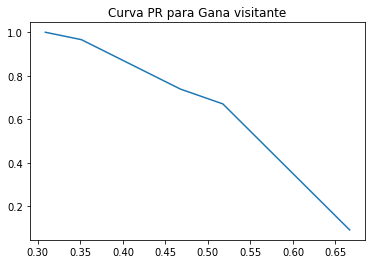

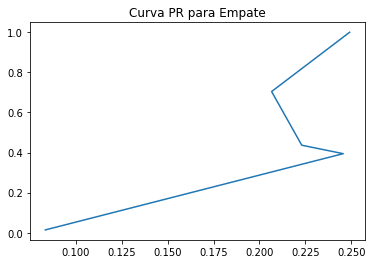

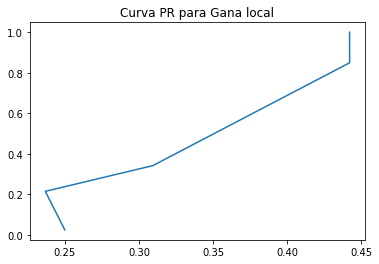

In [ ]:
from sklearn.metrics import precision_recall_curve
class_names=['Gana visitante', 'Empate', 'Gana local']
for nclass_label, class_label in enumerate([-1.0,0.0,1.0]):
  precision, recall, thresholds = precision_recall_curve(target_train,modelo.predict_proba(features_train)[:,0],pos_label=class_label)
  plt.plot(precision[:-1],recall[:-1])
  plt.title('Curva PR para '+str(class_names[nclass_label]))
  plt.show()

In [ ]:
precision_recall_curve?

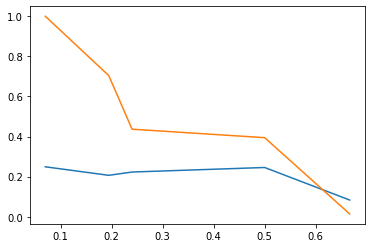

In [ ]:
plt.plot(thresholds,precision[:-1])
plt.plot(thresholds,recall[:-1])

Le cuesta predecir empates!

## Ejercicio:

- Incorpore los features de las apuestas. Optimice un DT. ¿Qué obtiene? ¿Puede decir algo sobre que feature es el más importante? ¿Qué da más información, los datos durante el juego, o las apuestas previas al juego?
- Incorpore los features diferenciales, sin las apuestas. ¿Qué obtiene?

# Regresión

Veamos como los árboles de decisión también sirven para regresión.

Trabajemos con un dataset sintetico:

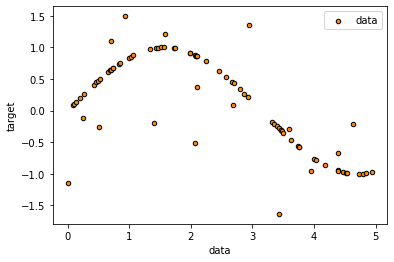

In [ ]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 3 * (0.5 - rng.rand(16))

X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]


# Plot the results
plt.figure()
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.xlabel("data")
plt.ylabel("target")
#plt.title("Decision Tree Regression")
plt.legend()
plt.show()

Podemos utilizar un árbol de decisión. Veamos que hace para dos profundidades distintas:

In [ ]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X, y)
regr_2.fit(X, y)
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)

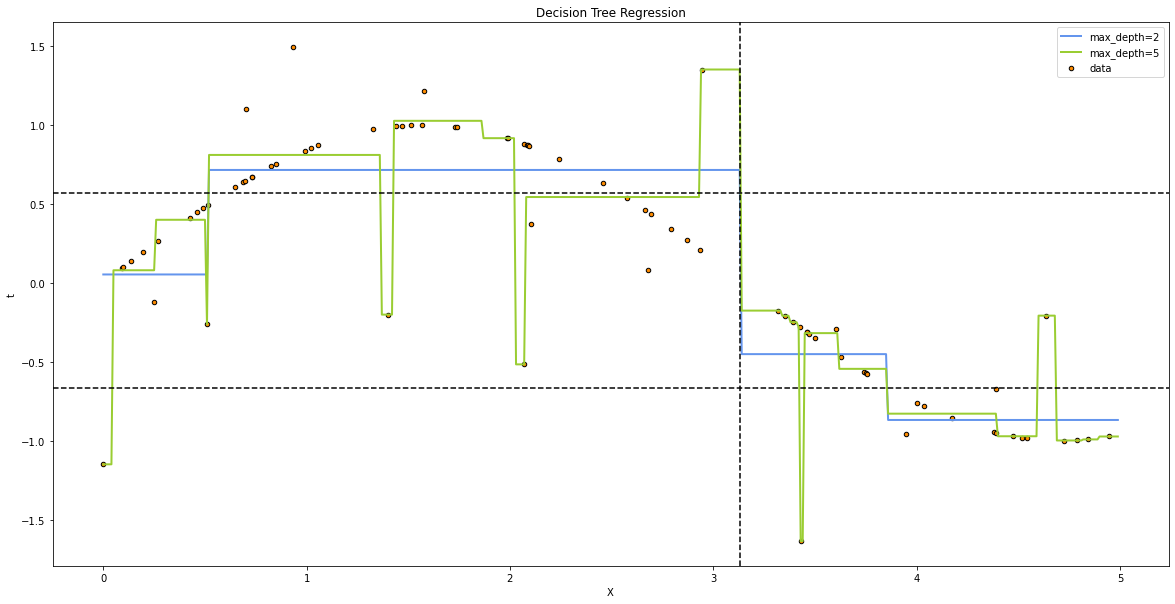

In [ ]:
# Plot the results
plt.figure(figsize=(20,10))
plt.scatter(X, y, s=20, edgecolor="black",
            c="darkorange", label="data")
plt.plot(X_test, y_1, color="cornflowerblue",
         label="max_depth=2", linewidth=2)
plt.plot(X_test, y_2, color="yellowgreen", label="max_depth=5", linewidth=2)
plt.axvline(3.133,linestyle='dashed',color='black')
plt.axhline(0.571,linestyle='dashed',color='black')
plt.axhline(-0.667,linestyle='dashed',color='black')
plt.xlabel("X")
plt.ylabel("t")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()

El árbol decide poniendo cortes que valor del target asignar. `max_depth` controla nuevamente cuantos cortes hace el algoritmo. Veamos como decide!

In [ ]:
mean_squared_error(np.mean(y)*np.ones(len(y)),y)

0.5471130002937142

In [ ]:
y_primer_corte=y[(X[:,0]<=3.133)]
print(np.mean(y_primer_corte))
print(mean_squared_error(np.mean(y_primer_corte)*np.ones(len(y_primer_corte)),y_primer_corte))

0.5711567593351029
0.23136965662280937


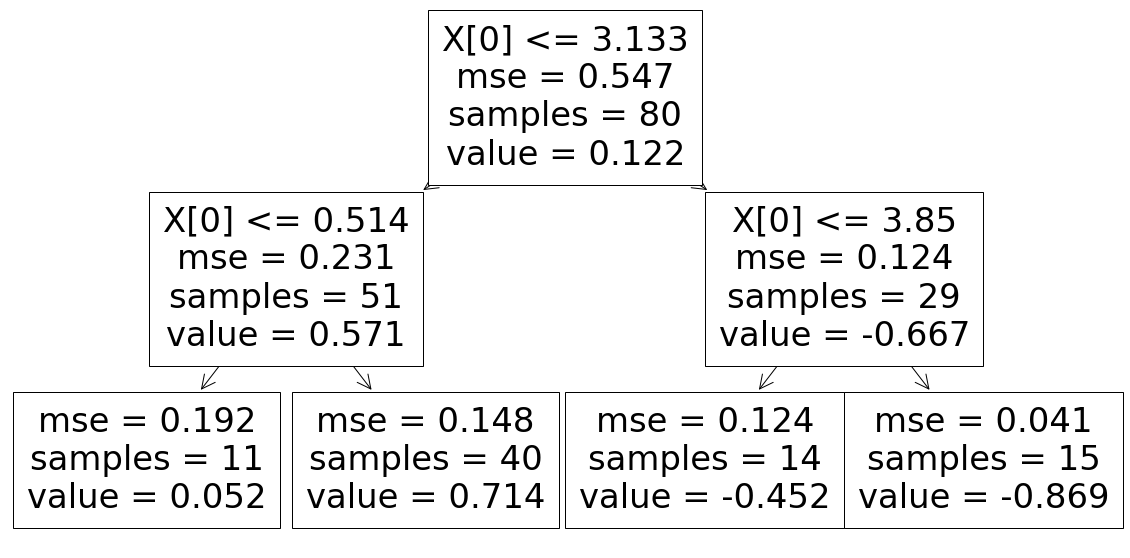

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(regr_1) 
plt.show()

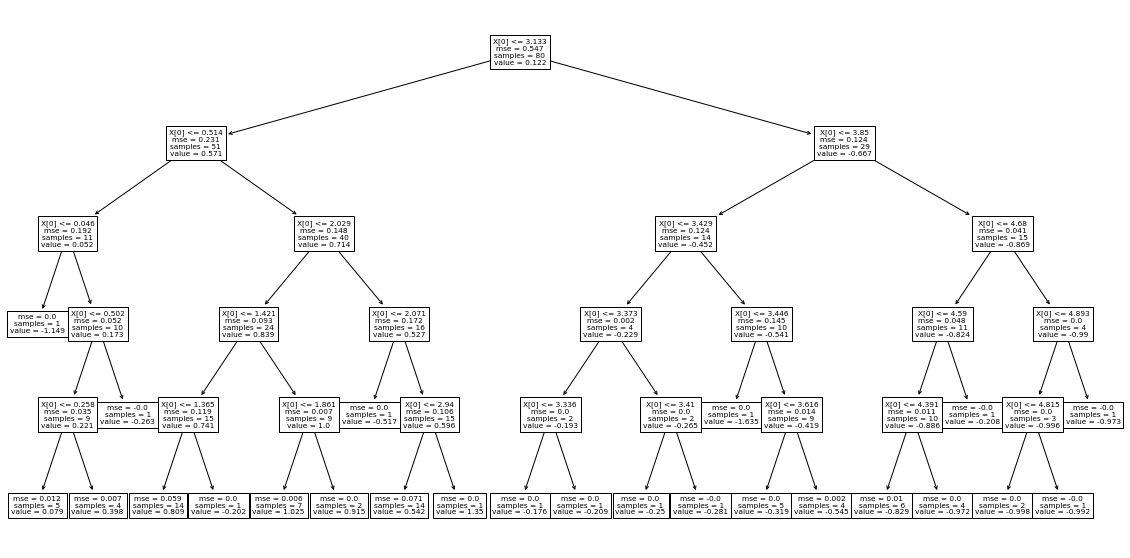

In [ ]:
plt.figure(figsize=(20,10))
tree.plot_tree(regr_2) 
plt.show()

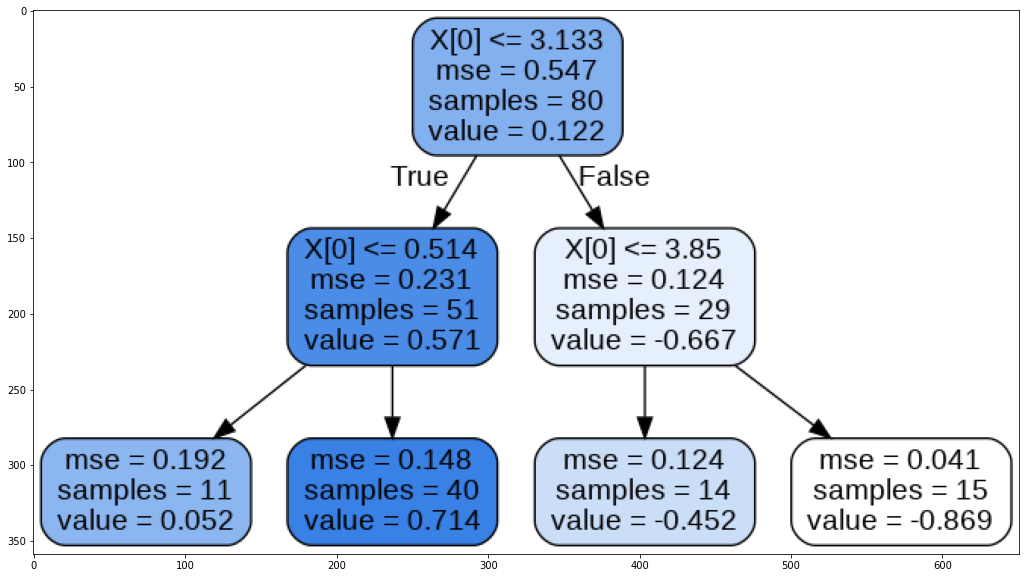

In [ ]:
tree.export_graphviz(
regr_1,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (20, 10))
plt.imshow(img)

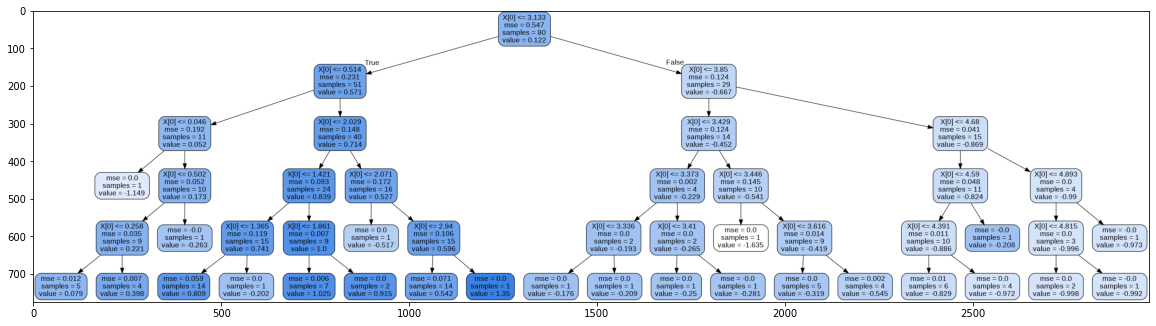

In [ ]:
tree.export_graphviz(
regr_2,
out_file="reg_tree.dot",
rounded=True,
filled=True
)

#Convierto el dot a png
! dot -Tpng reg_tree.dot -o reg_tree.png

#Ploteamos el png
img = cv2.imread('reg_tree.png')
plt.figure(figsize = (20, 20))
plt.imshow(img)

En efecto, no utiliza Gini ni entropía para elegir el feature donde cortar y el valor de corte, sino que utiliza el MSE. Existen otros errores que se pueden utilizar.

## Ejercicio:

Consideremos nuevamente el dataset de California. Obtenga un regresor a partir de un Árbol de Decisión optimizado. Reporte el RMSE y grafique predicciones contra valores verdaderos.

In [ ]:
HOUSING_PATH = "datasets"
import pandas as pd
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
import os
import sys
if 'google.colab' in sys.modules:
        
    import tarfile

    DOWNLOAD_ROOT = "https://github.com/ageron/handson-ml2/raw/master/"
    HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

    !mkdir -p ./datasets/housing

    def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
        os.makedirs(housing_path, exist_ok=True)
        tgz_path = os.path.join(housing_path, "housing.tgz")
        #urllib.request.urlretrieve(housing_url, tgz_path)
        !wget {HOUSING_URL} -P {housing_path}
        housing_tgz = tarfile.open(tgz_path)
        housing_tgz.extractall(path=housing_path)
        housing_tgz.close()

    # Corramos la función
    fetch_housing_data()

else: 
    print("Not running on Google Colab. This cell is did not do anything.")

--2021-05-10 15:15:50--  https://github.com/ageron/handson-ml2/raw/master/datasets/housing/housing.tgz
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz [following]
--2021-05-10 15:15:50--  https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.tgz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 409488 (400K) [application/octet-stream]
Saving to: ‘datasets/housing.tgz’

housing.tgz         100%[===================>] 399.89K  --.-KB/s    in 0.01s   

2021-05-10 15:15:51 (35.7 MB/s) - ‘datasets/housing.tgz’ saved [4

In [ ]:
housing_pre = load_housing_data()
from sklearn.model_selection import StratifiedShuffleSplit

housing_pre["income_cat"] = pd.cut(housing_pre["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=445543)
for train_index, test_index in split.split(housing_pre, housing_pre["income_cat"]):
    california_housing_train = housing_pre.loc[train_index]
    california_housing_test = housing_pre.loc[test_index]

for set_ in (california_housing_train, california_housing_test):
    set_.drop("income_cat", axis=1, inplace=True)

In [ ]:
housing=california_housing_train.copy()

problematic_columns = ['median_house_value', 'housing_median_age', 'median_income']
max_values=[]
for col in problematic_columns:
    max_value = housing[col].max()
    print(f"{col}: {sum(housing[col] == max_value)} districts with {col} = {max_value} ({round(sum(housing[col] == max_value)/len(housing)*100,2)}%).")
    max_values.append(max_value)

housing_clean = housing.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_clean = housing_clean[housing_clean[col] != max_value]

housing_test=california_housing_test.copy()
housing_test_clean = housing_test.copy()
for col, max_value in zip(problematic_columns, max_values):
    housing_test_clean = housing_test_clean[housing_test_clean[col] != max_value]

median_house_value: 762 districts with median_house_value = 500001.0 (4.61%).
housing_median_age: 997 districts with housing_median_age = 52.0 (6.04%).
median_income: 42 districts with median_income = 15.0001 (0.25%).


In [ ]:
housing_clean["rooms_per_household"] = housing_clean["total_rooms"]/housing_clean["households"]
housing_clean["bedrooms_per_room"] = housing_clean["total_bedrooms"]/housing_clean["total_rooms"]
housing_clean["population_per_household"]=housing_clean["population"]/housing_clean["households"]

housing_test_clean["rooms_per_household"] = housing_test_clean["total_rooms"]/housing_test_clean["households"]
housing_test_clean["bedrooms_per_room"] = housing_test_clean["total_bedrooms"]/housing_test_clean["total_rooms"]
housing_test_clean["population_per_household"]=housing_test_clean["population"]/housing_test_clean["households"]

In [ ]:
housing_labels = housing_clean["median_house_value"].copy()
housing_clean = housing_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_num = housing_clean.drop("ocean_proximity", axis=1)

housing_test_labels = housing_test_clean["median_house_value"].copy()
housing_test_clean = housing_test_clean.drop("median_house_value", axis=1) # drop labels for training set
housing_test_num = housing_test_clean.drop("ocean_proximity", axis=1)

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),#hay mas opciones aca
        ('std_scaler', StandardScaler()),
    ])

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing_clean)
housing_test_prepared=full_pipeline.transform(housing_test_clean)

# Ejemplo copado

Un ejemplo muy divertido que aparece en la documentación de `sklearn` es el siguiente:

In [ ]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.utils.validation import check_random_state

# Load the faces datasets
data, targets = fetch_olivetti_faces(return_X_y=True)

Vamos a aprender a dibujar la mitad inferior de las caras utilizando la mitad superior

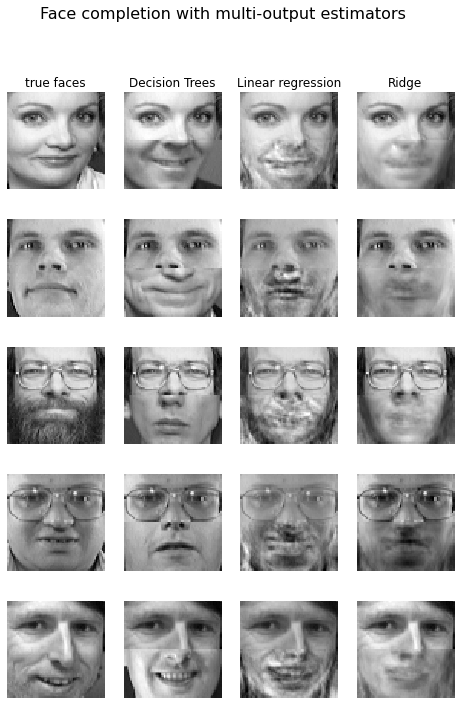

In [ ]:
train = data[targets < 30]
test = data[targets >= 30]  # Test on independent people

# Test on a subset of people
n_faces = 5
rng = check_random_state(4)
face_ids = rng.randint(test.shape[0], size=(n_faces, ))
test = test[face_ids, :]

n_pixels = data.shape[1]
# Upper half of the faces
X_train = train[:, :(n_pixels + 1) // 2]
# Lower half of the faces
y_train = train[:, n_pixels // 2:]
X_test = test[:, :(n_pixels + 1) // 2]
y_test = test[:, n_pixels // 2:]

# Fit estimators
ESTIMATORS = {
    "Decision Trees": DecisionTreeRegressor(),
    "Linear regression": LinearRegression(),
    "Ridge": RidgeCV(),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    estimator.fit(X_train, y_train)
    y_test_predict[name] = estimator.predict(X_test)

# Plot the completed faces
image_shape = (64, 64)

n_cols = 1 + len(ESTIMATORS)
plt.figure(figsize=(2. * n_cols, 2.26 * n_faces))
plt.suptitle("Face completion with multi-output estimators", size=16)

for i in range(n_faces):
    true_face = np.hstack((X_test[i], y_test[i]))

    if i:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1)
    else:
        sub = plt.subplot(n_faces, n_cols, i * n_cols + 1,
                          title="true faces")

    sub.axis("off")
    sub.imshow(true_face.reshape(image_shape),
               cmap=plt.cm.gray,
               interpolation="nearest")

    for j, est in enumerate(sorted(ESTIMATORS)):
        completed_face = np.hstack((X_test[i], y_test_predict[est][i]))

        if i:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j)

        else:
            sub = plt.subplot(n_faces, n_cols, i * n_cols + 2 + j,
                              title=est)

        sub.axis("off")
        sub.imshow(completed_face.reshape(image_shape),
                   cmap=plt.cm.gray,
                   interpolation="nearest")

plt.show()